https://www.alpha-i.co/blog/MNIST-for-ML-beginners-The-Bayesian-Way.html

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from edward.models import Categorical, Normal
import edward as ed
import pandas as pd
import pickle
ed.set_seed(314159)

In [2]:
# Use the TensorFlow method to download and/or load the data.
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
#two-layer neural network.
def neural_network(x, W_0, W_1, b_0, b_1):
    h = tf.matmul(x, W_0) + b_0
    h = tf.tanh(h)
    #h = tf.exp(tf.negative(tf.square(h)))
    h = tf.matmul(h, W_1) + b_1
    return h

def display_draws(loss, train_x, EPOCH_NUM):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
    plt.plot(np.arange(EPOCH_NUM), loss / len(train_x), label='Train')
    plt.legend(fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel('Negated ELBO', fontsize=15)
    plt.show()

In [4]:
%run optim.py

In [5]:
total = mnist.train.num_examples #number of training examples
N = total/100   # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100    # number of neurons.

In [5]:
epoch_num=100
m0=100

In [6]:
mcbatch = range(m0,m0+100*100)

In [6]:
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))

In [7]:
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))

In [8]:
epoch_num = 200
train_losssgd = np.zeros(epoch_num)

In [9]:
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

In [10]:
learning_rate = 5e-6
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

In [11]:
inference.initialize(optimizer=optimizer,n_print=100, n_samples = mcbatch)

In [12]:
# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()

In [13]:
obj = inference.build_loss_and_gradients(tf.trainable_variables())

In [14]:
newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

# SGD

In [15]:
for i in (0,total/N):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_losssgd[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

for epoch in range(1,epoch_num):
    for i in (0,total/N):
        print(epoch)
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        grads = tf.gradients(newloss, tf.trainable_variables())
        var_updates = []
        var_list = tf.trainable_variables()
        for grad, var in zip(grads, var_list):
            var_updates.append(var.assign_sub(learning_rate * grad))
        train_op = tf.group(*var_updates)
        sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
        #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssgd[epoch] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

In [16]:
for epoch in range(1,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssgd[epoch] = info_dict['loss']
    #inference.print_progress(info_dict)

5000/5000 [100%] ██████████████████████████████ Elapsed: 53s | Loss: 70273.406

In [17]:
sgd = train_losssgd[0:100]
#save loss
with open('losses/sgdlossbb', 'wb') as fp:
    pickle.dump(sgd, fp)

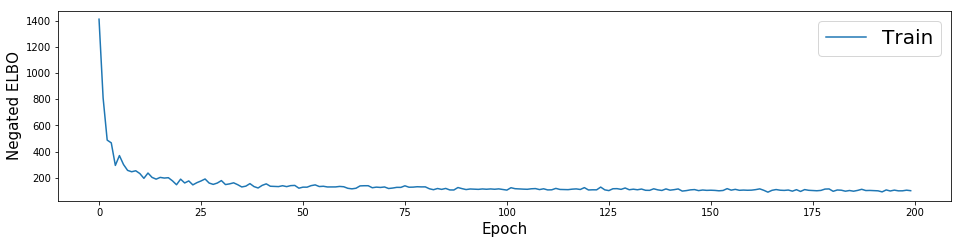

In [18]:
display_draws(train_losssgd, X_batch, epoch_num)

# SAG

In [6]:
total = mnist.train.num_examples #number of training examples
N = total/100  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100    # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 100
train_losssag = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-6
optimizer = tf.train.GradientDescentOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100, n_samples = mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [7]:
gradients = []#First pass over the data with SGD (keeping in memory all the gradients)
for _ in range(0,total, N):
    print(_)
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    gradients.append(grads)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_losssag[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

0
550
1100
1650
2200
2750
3300
3850
4400
4950
5500
6050
6600
7150
7700
8250
8800
9350
9900
10450
11000
11550
12100
12650
13200
13750
14300
14850
15400
15950
16500
17050
17600
18150
18700
19250
19800
20350
20900
21450
22000
22550
23100
23650
24200
24750
25300
25850
26400
26950
27500
28050
28600
29150
29700
30250
30800
31350
31900
32450
33000
33550
34100
34650
35200
35750
36300
36850
37400
37950
38500
39050
39600
40150
40700
41250
41800
42350
42900
43450
44000
44550
45100
45650
46200
46750
47300
47850
48400
48950
49500
50050
50600
51150
51700
52250
52800
53350
53900
54450


In [ ]:
#SAG (replacing the gradients of the selected indices)
for epoch in range(1,epoch_num):
    for i in range(0,total/N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        grads = tf.gradients(newloss, tf.trainable_variables())
        gradients[i] = grads
        var_updates = []
        var_list = tf.trainable_variables()
        for gradstemp in gradients:
            for grad, var in zip(gradstemp, var_list):
                var_updates.append(var.assign_sub(learning_rate * grad))
        train_op = tf.group(*var_updates)
        sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
        #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_losssag[epoch] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})
    if epoch%10==0:
        print(epoch)

In [13]:
sag = train_losssag[0:100]

In [18]:
#save loss
with open('losses/saglossbb', 'wb') as fp:
    pickle.dump(sag, fp)

In [ ]:
#For repu server
sag = train_losssag[0:100]
#save loss
with open('saglossbb', 'wb') as fp:
    pickle.dump(sag, fp)

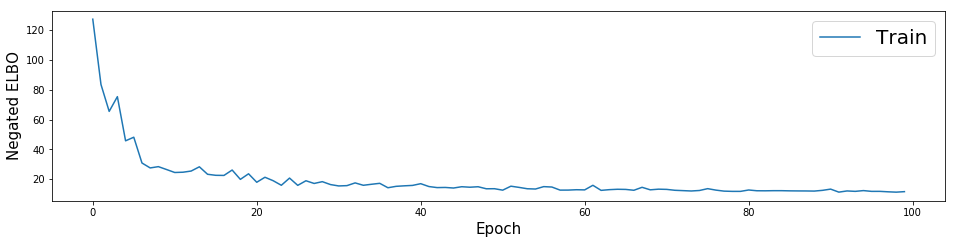

In [9]:
display_draws(train_losssag[0:100], X_batch, 100)

# ADAM

In [6]:
total = mnist.train.num_examples #number of training examples
N = total/100  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100    # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 100
train_lossadam = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-3
optimizer = tf.train.AdamOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100, n_samples = mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [7]:
for epoch in range(0,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossadam[epoch] = info_dict['loss']
    #inference.print_progress(info_dict)
    if epoch%10==0:
        print(epoch)

0
10
20
30
40
50
60
70
80
90


In [8]:
adam = train_lossadam[0:100]
#save loss
with open('losses/adamlossbb', 'wb') as fp:
    pickle.dump(adam, fp)

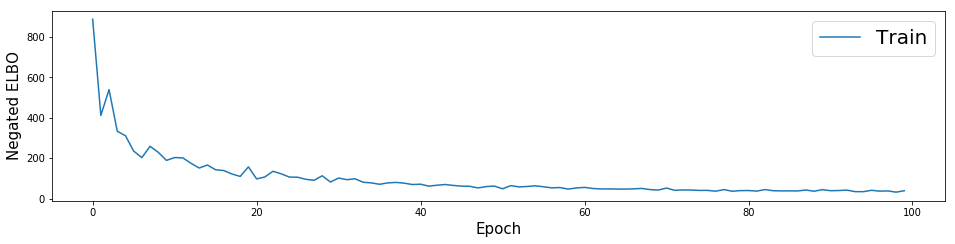

In [9]:
display_draws(train_lossadam, X_batch, epoch_num)

In [ ]:
adam = train_lossadam[0:100]
#save loss
with open('adamlossbb', 'wb') as fp:
    pickle.dump(adam, fp)

# RMSPROP

In [7]:
total = mnist.train.num_examples #number of training examples
N = total/100  # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 100
train_lossrms = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-3
optimizer = tf.train.RMSPropOptimizer(learning_rate)

inference.initialize(optimizer=optimizer,n_print=100, n_samples = mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [8]:
for epoch in range(0,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossrms[epoch] = info_dict['loss']
    #inference.print_progress(info_dict)
    if epoch%10==0:
        print(epoch)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [9]:
rms = train_lossrms[0:100]
#save loss
with open('losses/rmslossbb', 'wb') as fp:
    pickle.dump(rms, fp)

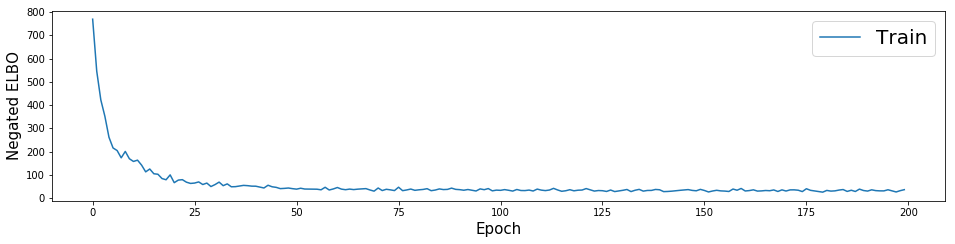

In [10]:
display_draws(train_lossrms, X_batch, epoch_num)

# Momentum

http://ruder.io/optimizing-gradient-descent/index.html#momentum

In [6]:
total = mnist.train.num_examples #number of training examples
N = total/100 # number of images in a minibatch.
D = 784   # number of features.
K = 10    # number of classes.
P = 100   # number of neurons.
# Create a placeholder to hold the data (in minibatches) in a TensorFlow graph.
x = tf.placeholder(tf.float32, [None, D])
# Normal(0,1) priors for the variables. Note that the syntax assumes TensorFlow 1.1.
w0 = Normal(loc=tf.zeros([D, P]), scale=tf.ones([D, P]))
b0 = Normal(loc=tf.zeros(P), scale=tf.ones(P))
w1 = Normal(loc=tf.zeros([P, K]), scale=tf.ones([P, K]))
b1 = Normal(loc=tf.zeros(K), scale=tf.ones(K))
# Categorical likelihood for classication.
y =Categorical(neural_network(x, w0,w1, b0, b1))
# Contruct the q(w) and q(b). in this case we assume Normal distributions.
qw0 = Normal(loc=tf.Variable(tf.random_normal([D, P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, P]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([P])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([P, K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([P, K]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([K])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([K]))))
epoch_num = 100
train_lossmoment = np.zeros(epoch_num)
# We use a placeholder for the labels in anticipation of the traning data.
y_ph = tf.placeholder(tf.int32, [N])
# Define the VI inference technique, ie. minimise the KL divergence between q and p.
inference = elbo_optimizer({w0: qw0, b0: qb0,w1:qw1,b1:qb1}, data={y:y_ph})

learning_rate = 5e-5
momentum = 5e-5
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)

inference.initialize(optimizer=optimizer,n_print=100, n_samples = mcbatch)

# We will use an interactive session.
sess = tf.InteractiveSession()
# Initialise all the vairables in the session.
tf.global_variables_initializer().run()
obj = inference.build_loss_and_gradients(tf.trainable_variables())

newloss = obj[0]
newvars = obj[1][0:4]
newgrads = obj[1][4:8]

In [7]:
for i in (0,total/N):
    X_batch, Y_batch = mnist.train.next_batch(N)
    # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
    Y_batch = np.argmax(Y_batch,axis=1)
    grads = tf.gradients(newloss, tf.trainable_variables())
    var_updates = []
    var_list = tf.trainable_variables()
    for grad, var in zip(grads, var_list):
        var_updates.append(var.assign_sub(learning_rate * grad))
    train_op = tf.group(*var_updates)
    sess.run(train_op,feed_dict={x: X_batch, y_ph: Y_batch})
    #info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
train_lossmoment[0] = sess.run(newloss,feed_dict={x: X_batch, y_ph: Y_batch})

In [8]:
for epoch in range(1,epoch_num):
    for _ in range(0, total, N):
        X_batch, Y_batch = mnist.train.next_batch(N)
        # TensorFlow method gives the label data in a one hot vetor format. We convert that into a single label.
        Y_batch = np.argmax(Y_batch,axis=1)
        info_dict = inference.update(feed_dict={x: X_batch, y_ph: Y_batch})
        
    train_lossmoment[epoch] = info_dict['loss']
    #inference.print_progress(info_dict)
    if epoch%10==0:
        print(epoch)

10
20
30
40
50
60
70
80
90


In [9]:
moment = train_lossmoment[0:100]
#save loss
with open('losses/momentlossbb', 'wb') as fp:
    pickle.dump(moment, fp)

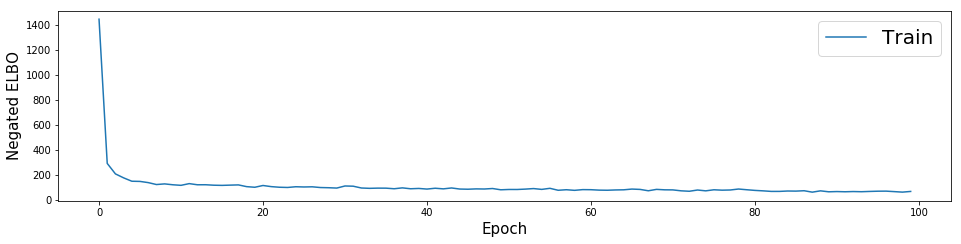

In [10]:
display_draws(train_lossmoment, X_batch, epoch_num)

# Comparison

In [6]:
X_batch, Y_batch = mnist.train.next_batch(N)

In [7]:
with open ('losses/sgdlossbb', 'rb') as fp:
    sgdsb = pickle.load(fp)
with open ('losses/adamlossbb', 'rb') as fp:
    adamsb = pickle.load(fp)
with open ('losses/rmslossbb', 'rb') as fp:
    rmssb = pickle.load(fp)
with open ('losses/momentlossbb', 'rb') as fp:
    momentsb = pickle.load(fp)
with open ('losses/sgdloss', 'rb') as fp:
    sgd = pickle.load(fp)
with open ('losses/adamloss', 'rb') as fp:
    adam = pickle.load(fp)
with open ('losses/rmsloss', 'rb') as fp:
    rms = pickle.load(fp)
with open ('losses/momentloss', 'rb') as fp:
    moment = pickle.load(fp)

In [8]:
with open ('losses/sagloss', 'rb') as fp:
    sag = pickle.load(fp)
with open ('losses/saglossbb', 'rb') as fp:
    sagsb = pickle.load(fp)

# 1% batch

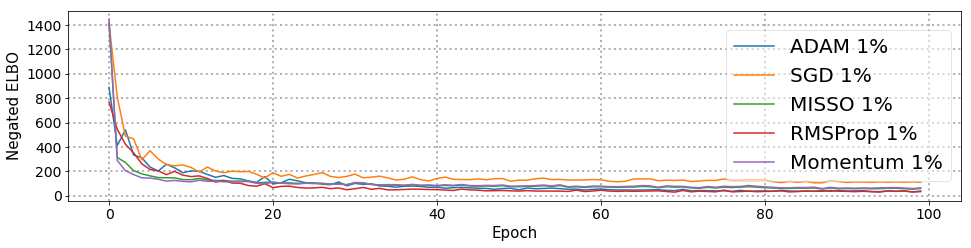

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(100), adamsb / len(X_batch), label='ADAM 1%')
plt.plot(np.arange(100), sgdsb / len(X_batch), label='SGD 1%')
plt.plot(np.arange(100), sagsb / len(X_batch), label='MISSO 1%')
plt.plot(np.arange(100), rmssb / len(X_batch), label='RMSProp 1%')
plt.plot(np.arange(100), momentsb / len(X_batch), label='Momentum 1%')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Negated ELBO', fontsize=15)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)
plt.show()

# 10% batch

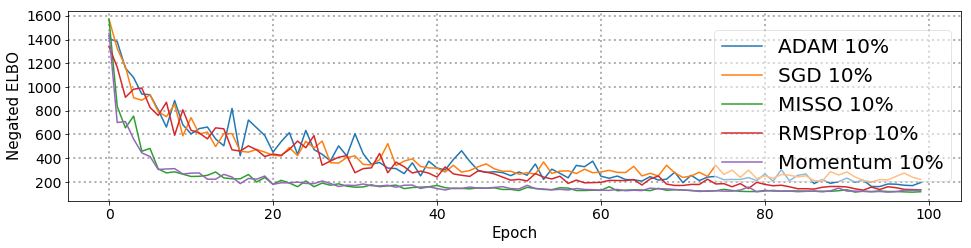

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(100), adam / len(X_batch), label='ADAM 10%')
plt.plot(np.arange(100), sgd / len(X_batch), label='SGD 10%')
plt.plot(np.arange(100), sag / len(X_batch), label='MISSO 10%')
plt.plot(np.arange(100), rms / len(X_batch), label='RMSProp 10%')
plt.plot(np.arange(100), moment / len(X_batch), label='Momentum 10%')
leg = plt.legend(fontsize=20,fancybox=True, loc='right')
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Negated ELBO', fontsize=15)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)
plt.show()

In [16]:
end = 15

In [17]:
xaxis = np.arange(1,end+1)

In [18]:
adamsb = adamsb[0:end]
sgdsb = sgdsb[0:end]
sagsb = sagsb[0:end]
momentsb = momentsb[0:end]
rmssb = rmssb[0:end]

adam = adam[0:end]
sgd = sgd[0:end]
sag = sag[0:end]
moment = moment[0:end]
rms = rms[0:end]

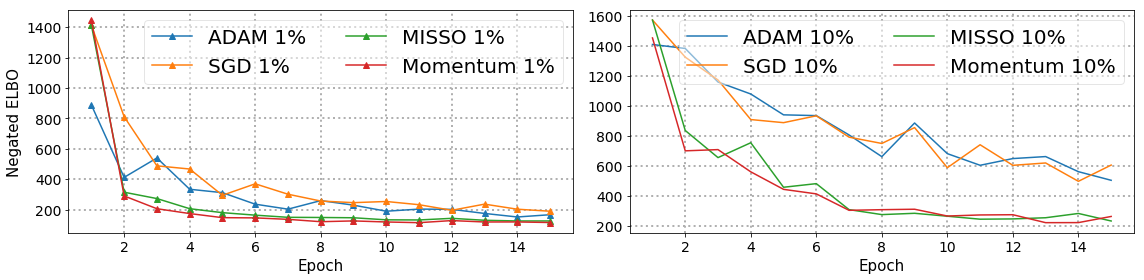

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
plt.subplot(1, 2, 1)
plt.plot(xaxis, adamsb / len(X_batch), label='ADAM 1%', marker='^')
plt.plot(xaxis, sgdsb / len(X_batch), label='SGD 1%', marker='^')
plt.plot(xaxis, sagsb / len(X_batch), label='MISSO 1%', marker='^')
plt.plot(xaxis, momentsb / len(X_batch), label='Momentum 1%', marker='^')
leg = plt.legend(fontsize=20,fancybox=True, loc=1,ncol=2)
leg.get_frame().set_alpha(0.5)
plt.xticks(fontsize=14)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)

plt.subplot(1, 2, 2)
plt.plot(xaxis, adam / len(X_batch), label='ADAM 10%')
plt.plot(xaxis, sgd / len(X_batch), label='SGD 10%')
plt.plot(xaxis, sag / len(X_batch), label='MISSO 10%')
plt.plot(xaxis, moment / len(X_batch), label='Momentum 10%')

leg = plt.legend(fontsize=20,fancybox=True, loc=1,ncol=2)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)
fig.tight_layout()
plt.show()

In [20]:
fig.savefig("bnnwithrms.png",bbox_inches = 'tight')

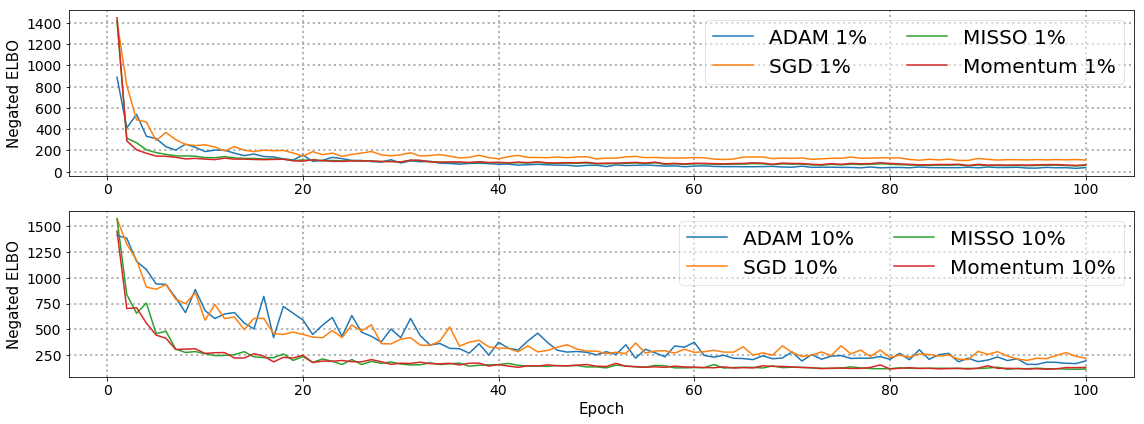

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))
plt.subplot(2, 1, 1)
plt.plot(xaxis, adamsb / len(X_batch), label='ADAM 1%')
plt.plot(xaxis, sgdsb / len(X_batch), label='SGD 1%')
plt.plot(xaxis, sagsb / len(X_batch), label='MISSO 1%')
plt.plot(xaxis, momentsb / len(X_batch), label='Momentum 1%')
leg = plt.legend(fontsize=20,fancybox=True, loc=1,ncol=2)
leg.get_frame().set_alpha(0.5)
plt.xticks(fontsize=14)
plt.ylabel('Negated ELBO', fontsize=15)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)

plt.subplot(2, 1, 2)
plt.plot(xaxis, adam / len(X_batch), label='ADAM 10%')
plt.plot(xaxis, sgd / len(X_batch), label='SGD 10%')
plt.plot(xaxis, sag / len(X_batch), label='MISSO 10%')
plt.plot(xaxis, moment / len(X_batch), label='Momentum 10%')

leg = plt.legend(fontsize=20,fancybox=True, loc=1,ncol=2)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Negated ELBO', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)
fig.tight_layout()
plt.show()

In [45]:
fig.savefig("bnn3.png",bbox_inches = 'tight')

### Comparison batch size

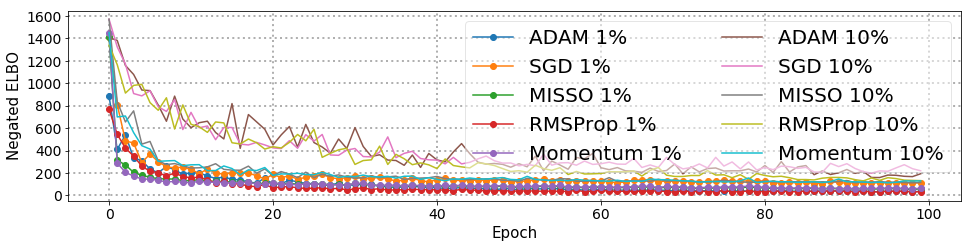

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(100), adamsb / len(X_batch), label='ADAM 1%', marker='o')
plt.plot(np.arange(100), sgdsb / len(X_batch), label='SGD 1%', marker='o')
plt.plot(np.arange(100), sagsb / len(X_batch), label='MISSO 1%', marker='o')
plt.plot(np.arange(100), rmssb / len(X_batch), label='RMSProp 1%', marker='o')
plt.plot(np.arange(100), momentsb / len(X_batch), label='Momentum 1%', marker='o')

p1 = plt.plot(np.arange(100), adam / len(X_batch), label='ADAM 10%')
p2 = plt.plot(np.arange(100), sgd / len(X_batch), label='SGD 10%')
plt.plot(np.arange(100), sag / len(X_batch), label='MISSO 10%')
plt.plot(np.arange(100), rms / len(X_batch), label='RMSProp 10%')
plt.plot(np.arange(100), moment / len(X_batch), label='Momentum 10%')

leg = plt.legend(fontsize=20,fancybox=True, loc=1,ncol=2)
leg.get_frame().set_alpha(0.5)
plt.xlabel('Epoch', fontsize=15)
plt.xticks(fontsize=14)
plt.ylabel('Negated ELBO', fontsize=15)
plt.yticks(fontsize=14)
plt.grid(linestyle='dotted',linewidth=2)
plt.show()